# Homework 3

Expand upon our understanding of image registration by following the photomosaicking work in the Pizarro2003joe paper

## Part 1

Modify the registration module from the previous homework to allow for a robust feature matching across two images. <br>
Normalize the images before matching them <br>
Use the Levenberg Marquadt algorithm for computing the homography on the inlier set that we obtain after feature matching with any feature/descriptor in combination with outlier rejection via RANSAC<br><br>
Run the registration code to match the 6 images in a loop and the images that are non sequential and might have smaller overlap

In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import os

In [4]:
# Save images in a list
imgs = []
dir_name = 'Part1_6Images/'
list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(dir_name + '*') ) )

for file_path in list_of_files:
    imgs.append(cv2.imread(file_path))

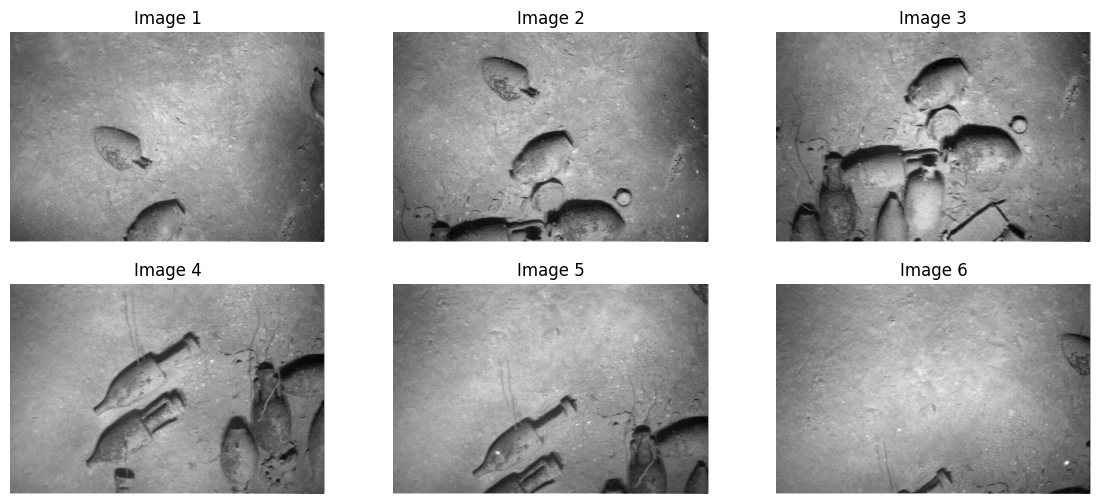

In [5]:
def show_images(num_rows, num_columns, imgs, isGrayscale=False):
    f, axs = plt.subplots(num_rows, num_columns,figsize=(14,6))
    for i in range(num_rows):
        for j in range(num_columns):
            img_num = i*num_columns + j
            axs[i,j].imshow(imgs[img_num], cmap='gray' if isGrayscale else 'viridis')
            axs[i,j].title.set_text("Image " + str(img_num+1))
            axs[i,j].axis('off')


show_images(2, 3, imgs)

# for ax in axs.ravel():
#     ax.set_axis_off()

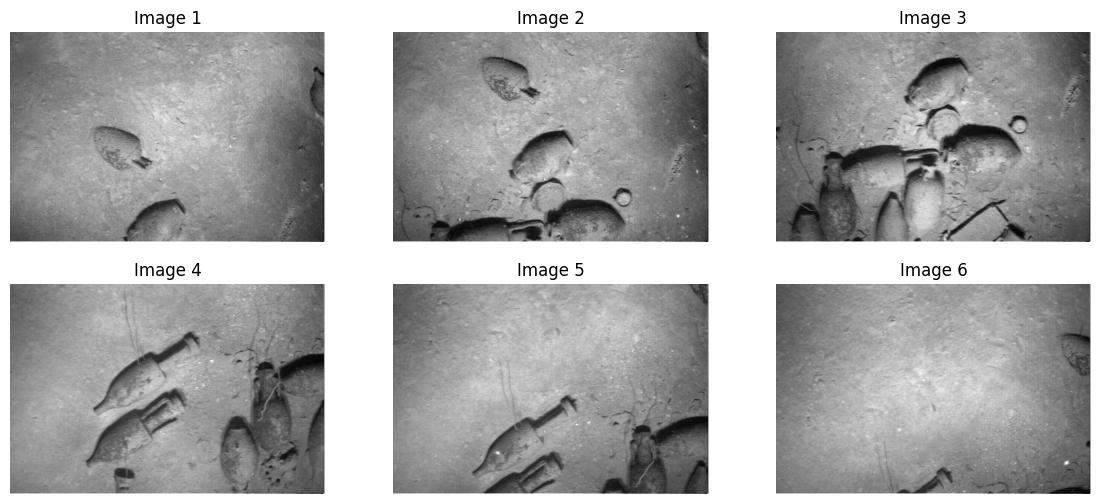

In [6]:
# Normalize Grayscaled Images for better contrast:
def normalize_images(imgs):
    imgs_norm = []
    for img in imgs:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_norm = cv2.normalize(gr, None, 0, 255, cv2.NORM_MINMAX)
        imgs_norm.append(img_norm)
    return imgs_norm

def grayscale_images(imgs):
    imgs_gray = []
    for img in imgs:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        imgs_gray.append(gr)
    return imgs_gray

imgs_norm = normalize_images(imgs)
show_images(2, 3, imgs_norm, isGrayscale=True)

In [7]:
def get_non_max_suppression_mask(keypoints, img_dims):
    binary_image = np.zeros((img_dims[0], img_dims[1]))
    response_list = np.array([keypoint.response for keypoint in keypoints])
    mask = np.flip(np.argsort(response_list))
    point_list = np.rint([keypoint.pt for keypoint in keypoints])[
        mask].astype(int)
    non_max_suppression_mask = []
    for point, index in zip(point_list, mask):
        if binary_image[point[1], point[0]] == 0:
            non_max_suppression_mask.append(index)
            cv2.circle(binary_image, (point[0], point[1]), 2, 255, -1)

    return non_max_suppression_mask

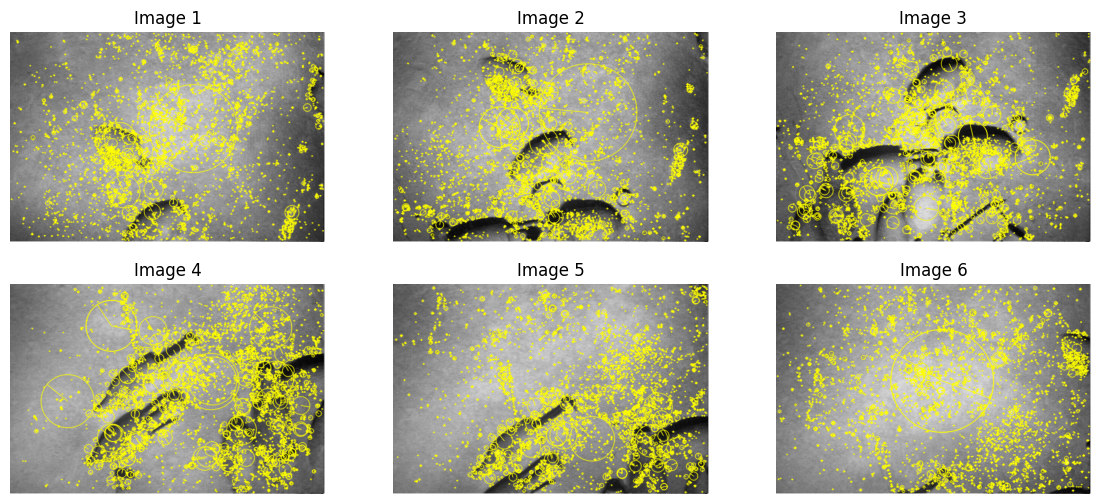

In [8]:
# Initialize SIFT object
sift = cv2.xfeatures2d.SIFT_create(nfeatures=4000,nOctaveLayers=12,contrastThreshold=0.025,sigma=1.5)

kp = []
des = []
imgs_sift = []
for img in imgs_norm:
    k, d = sift.detectAndCompute(img,None)
    non_max_suppression_mask = get_non_max_suppression_mask(k, img.shape)
    img_sift = cv2.drawKeypoints(img, k, img, color=[255,255,0], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    imgs_sift.append(img_sift)
    kp.append(np.array(k)[non_max_suppression_mask])
    des.append(np.array(d)[non_max_suppression_mask])

show_images(2, 3, imgs_sift)

In [9]:
# Use Zernike demo's feature matching function
def knn_match_and_lowe_ratio_filter(matcher, des1, des2,threshold=0.9, dist_mask_12=None, draw_plot_dist=False):
    # First match 2 against 1
    if dist_mask_12 is None:
        dist_mask_21 = None
    else:
        dist_mask_21 = dist_mask_12.T
    matches_knn = matcher.knnMatch(des2,des1, k=2, mask = dist_mask_21 )
    all_ds = [m[0].distance for m in matches_knn if len(m) >0]

    matches = []
    # Run lowes filter and filter with difference higher than threshold this might
    # still leave multiple matches into 1 (train descriptors)
    # Create mask of size des1 x des2 for permissible matches
    mask = np.zeros((des1.shape[0],des2.shape[0]),dtype='uint8')
    for match in matches_knn:
        if len(match)==1 or (len(match)>1 and match[0].distance < threshold*match[1].distance):
           # if match[0].distance < 75:
                matches.append(match[0])
                mask[match[0].trainIdx,match[0].queryIdx] = 1

    #matches = [m for m in matches if m.distance<5 ]

    if draw_plot_dist:
        fig, axes = plt.subplots(1, 1, num=3)
        filt_ds = [m.distance for m in matches]
        axes.plot(sorted(all_ds),'.',label = 'All Matches')
        axes.plot(sorted(filt_ds),'.',label = 'Filtered Matches')
        axes.set_xlabel('Number')
        axes.set_ylabel('Distance')
        axes.legend()
        plt.pause(.1)

    # run matches again using mask but from 1 to 2 which should remove duplicates
    # This is basically same as running cross match after lowe ratio test
    matches_cross = matcher.match(des1,des2,mask=mask)
    #print("Len of cross matches", len(matches_cross))
    return matches_cross

Run the feature matching over the image pairs sequentially<br>
1-2, 2-3, 3-4, 4-5, 5-6, 6-1

In [21]:
def getMatches(kp, des, onlyImagePair=False):
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = []
    # kp_match is a list of tuples with kp_match[i] = (kp0_match, kp1_match)
    kp_matches = [] 

    for i in range(6):
        ii = i+1 if i < 5 else 0
        matches.append(knn_match_and_lowe_ratio_filter(matcher,des[i],des[ii],threshold=0.90))
        kp0_match_pts = np.array([kp[i][mat.queryIdx].pt for mat in matches[i]])
        kp1_match_pts = np.array([kp[ii][mat.trainIdx].pt for mat in matches[i]])
            
        kp_matches.append((kp0_match_pts,kp1_match_pts))
    return matches, kp_matches

In [22]:
matches, kp_matches = getMatches(kp,des)

With matches for each image pair, perform RANSAC on the match points to get the inliers.

In [20]:
# Following procedure from Zernike demo
def ransac(kp, matches, kp_match):
    masks = []
    inliers = []

    i = 0

    for match in kp_match:
        F, mask = cv2.findFundamentalMat(match[0], match[1],
                                            method=cv2.FM_RANSAC,       
                                            ransacReprojThreshold=1.0,
                                            confidence=0.9999)
        masks.append(mask)

        ii = i+1 if i < 5 else 0
        kp0_match_inliers = [kp[i][mat.queryIdx] for mat, msk in zip(matches[i], mask[i]) if msk]
        kp1_match_inliers = [kp[ii][mat.trainIdx] for mat, msk in zip(matches[i], mask[i]) if msk]

        inliers.append((kp0_match_inliers, kp1_match_inliers))
        i+=1

    return inliers, masks

In [23]:
inliers, masks = ransac(kp, matches, kp_matches)

### Compute Homography using Levenberg Marquadt

In [28]:
# returns a list of homographies for each image pair of keypoints given
# the homographies map the left image (src) to the right image (dst)
def get_homography(kp_match_inliers):
    h = []
    pts_left_src = []
    pts_right_dst = []
    mask = []

    # if inliers were not already given to the homography function, get points and do RANSAC
    for kp_match in kp_match_inliers:
        pts_left_src.append(np.float32([kp_match[0][i] for i in range(len(kp_match[0]))]))
        pts_right_dst.append(np.float32([kp_match[1][i] for i in range(len(kp_match[1]))]))

    # this is only for the last run
    for i in range(len(pts_left_src)):
        h_img, mask_img = cv2.findHomography(pts_right_dst[i],pts_left_src[i],cv2.RANSAC,1.0)
        h.append(h_img)
        mask.append(mask_img)
    return h, mask

In [29]:
H, mask = get_homography(kp_matches)

Code from previous homework to stitch two images

In [44]:
def adjust_image_frame(H, src_shape, dst_shape):
    # Get corners of the source image
    (h, w) = src_shape
    img_corners = np.float32([[0, 0],
                            [w - 1, 0],
                            [w - 1, h - 1],
                            [0, h - 1]])
    
    # Convert to Array in Homogeneous Coordinates
    corners_base = np.array([img_corners[:, 0],
                            img_corners[:,1],
                            np.ones(4)])

    # Calculate distorted corner pixel coordinates by multiplying by Homography matrix
    corners_distorted = np.dot(H, corners_base)
    [x, y, c] = corners_distorted
    x = np.divide(x, c)
    y = np.divide(y, c)

    # Finding the dimentions of the distorted image frame
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))

    # Fit Right Side of Image
    w_stitched = max(max_x, dst_shape[1])
    h_stitched = max(max_y, dst_shape[0])

    # Add offset if distorted stitching goes out of current image frame
    offset = [0, 0]
    if min_x < 0:
        offset[0] = abs(min_x)
        w_stitched += offset[0]
    if min_y < 0:
        offset[1] = abs(min_y)
        h_stitched += offset[1]

    # Add offset to stitched corner coordinates
    corners_stitched = np.float32(np.array([x + offset[0], y + offset[1]]).transpose())

    # Recompute homography s.t. the source image is in frame
    H = cv2.getPerspectiveTransform(img_corners, corners_stitched)
    
    return [h_stitched, w_stitched], offset, H


def stitch_images(img_dst, img_src, H):
    # Finding size of new frame of stitched images and updating the homography matrix 
    stitched_dims, offset, H = adjust_image_frame(H, img_src.shape, img_dst.shape)

    # Finally placing the images upon one another.
    src_warped = cv2.warpPerspective(img_src, H, (stitched_dims[1], stitched_dims[0]))

    # Expand destimation image frame to fit source image
    dst_transformed = np.zeros((stitched_dims[0], stitched_dims[1]), dtype=np.uint8)
    dst_transformed[offset[1]:offset[1]+img_dst.shape[0], offset[0]:offset[0]+img_dst.shape[1]] = img_dst

    # Blend images together
    black = np.zeros((stitched_dims[0], stitched_dims[1]), dtype=np.uint8)
    mask_dst = cv2.inRange(dst_transformed, np.array([0,0,0]), np.array([5,5,5]))
    mask_src = cv2.inRange(src_warped, np.array([0,0,0]), np.array([0,0,0]))

    # Get the non-overlapping components of both images
    dst_fringe = cv2.bitwise_or(dst_transformed, src_warped, mask=mask_dst)
    src_fringe = cv2.bitwise_or(dst_transformed, src_warped, mask=mask_src)

    # Get the overlapping region and set it to white to use as a mask
    overlap_region = cv2.bitwise_and(
        cv2.bitwise_or(cv2.cvtColor(dst_transformed, cv2.COLOR_BGR2GRAY), cv2.cvtColor(src_warped, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_dst)),
        cv2.bitwise_or(cv2.cvtColor(dst_transformed, cv2.COLOR_BGR2GRAY), cv2.cvtColor(src_warped, cv2.COLOR_BGR2GRAY), mask=cv2.bitwise_not(mask_src)))
    overlap_region[overlap_region>0.0] = 255

    # Blend only the overlapping regions of the image
    img_overlap_blend = cv2.addWeighted(
        cv2.bitwise_or(src_warped, black, mask=overlap_region), 0.5,
        cv2.bitwise_or(dst_transformed, black, mask=overlap_region), 0.5, 0.0)

    # Combine all components of the image together
    img_stitched = dst_fringe + src_fringe + img_overlap_blend

    return img_stitched, offset

In [45]:
img_stitched, pix_offset = stitch_images(imgs_norm[0], imgs_norm[1], H[0])

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:1742: error: (-209:Sizes of input arguments do not match) The lower boundary is neither an array of the same size and same type as src, nor a scalar in function 'cv::inRange'


## Part 2
Go around the entire loop of 6 images and set up the problem by outputting vertices and edges in terms of a factor graph. Images that you manage to register in part (b) above can be thought of as loop closure events. <br>
Justify your choice of the covariance (and thus information) matrix that you use for each edge. Once you have completed the loop run a GTSAM script on the output vertices and edges and see how that <br>
(a) Affects the location of individual image centers - your "odometry" (make a plot before and after optimization)<br>
(b) Plot the covariances for each measurement before and after optimization

## Part 3
Now go to the set of 29 images and repeat everything you did in Part 2 above for this larger dataset. 

## Part 4 (optional)
Do it for the entire dataset